In this notebook, we'll use a pre-trained machine learning model to generate a submission to the [BirdClef2023 competition](https://www.kaggle.com/c/birdclef-2023).  The goal of the competition is to identify Eastern African bird species by sound.

## Step 1: Imports

In [2]:
# Install All libraries
!pip install -Uq fastcore fastai fastbook
!pip install image_tabular
!pip install kaggle
! [ -e /content ] && pip install -Uqq pip fastai git+https://github.com/drscotthawley/fastproaudio.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import files, drive
drive.mount("/content/gdrive")
# Switch do DeepLearning directory
%cd /content/gdrive/MyDrive/DeepLearning

Mounted at /content/gdrive
/content/gdrive/MyDrive/DeepLearning


In [4]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import random
import glob
import matplotlib.pyplot as plt
from typing import List

import csv
import io

import os

from IPython.display import Audio

import torchaudio
import torch

# To save spectrograms as png
import skimage.io

# fastproaudio
from fastproaudio.core import *


# Fastai
import fastbook
fastbook.setup_book()
from fastbook import *
from fastcore.transform import Transform
from fastai.torch_core import TensorBase
from fastai.data.core import TensorImageBase

# Import all the vision library
from fastai.vision.all import *


In [5]:
# Setup kaggle API

# 1. Read the kaggle API token to interact with your kaggle account
# Folder containing kaggle.json for kaggle API authorization
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/DeepLearning/"

In [6]:
!ls
# Pick a path to download the dataset to:
comp = 'birdclef-2023'
path = URLs.path(comp)
path_train = Path(path/'train_audio')

kaggle.json  path_spectrogram


In [7]:
#And use the Kaggle API to download the dataset to that path, and extract it:
Path.BASE_PATH = path

from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 4.91G/4.91G [02:13<00:00, 39.6MB/s]


(#3) [Path('train_metadata.csv'),Path('eBird_Taxonomy_v2021.csv'),Path('sample_submission.csv')]

# Pre-generate Spectrograms and save them
Generate spectrograms over 5-seconds splits of resampled audio files


In [8]:
Path(path/'train_audio/gybfis1').ls()

(#10) [Path('train_audio/gybfis1/XC131985.ogg'),Path('train_audio/gybfis1/XC127885.ogg'),Path('train_audio/gybfis1/XC282058.ogg'),Path('train_audio/gybfis1/XC397814.ogg'),Path('train_audio/gybfis1/XC282061.ogg'),Path('train_audio/gybfis1/XC282065.ogg'),Path('train_audio/gybfis1/XC618866.ogg'),Path('train_audio/gybfis1/XC267529.ogg'),Path('train_audio/gybfis1/XC396326.ogg'),Path('train_audio/gybfis1/XC267528.ogg')]

Get the paths to all audio files

In [9]:
def get_audio_files(path):
    return get_files(path, extensions='.ogg', recurse=True)

def get_npy_files(path):
    return get_files(path, extensions='.npy', recurse=True)

audio_files = get_audio_files(path)
fn = audio_files[0]; fn

Path('test_soundscapes/soundscape_29201.ogg')

In [10]:
def read_signal(audio_file_path: Path,
                  audio_split_length: float=5.,
                  audio_hop_length: float=1.,
                  sample_rate: int=32000):
    # Load audio sample from file path
    sig, rate = librosa.load(audio_file_path)    
    # Resample to match desired sample rate
    resampled_sig = librosa.resample(sig, orig_sr=rate, target_sr=sample_rate)
    return resampled_sig.astype(float, copy=False)

def split_signal(resampled_sig: np.ndarray,
                  audio_split_length: float=5.,
                  audio_hop_length: float=1.,
                  sample_rate: int=32000):
    "Split signal into chunks of desired length. Returns a list a those chunks" 

    len_chunk = int(audio_split_length*sample_rate)
    len_sig = len(resampled_sig)

    # If length of signal inferior to desired length, pad it with zeros
    if (len_sig <= len_chunk):
      res = np.zeros(len_chunk)
      res[:len_sig] = resampled_sig
      return [res]
    else:
      res = []
      # Create chunks. To avoid padding, the last chunk will start audio_split_length seconds before the signal end.
      start = 0
      hop = int(sample_rate*audio_hop_length)

      while(start+len_chunk <= len_sig):
        res.append(resampled_sig[start:start+len_chunk])
        start+=hop

    # Append last chunk
      res.append(resampled_sig[len_sig-len_chunk:])

      return res


def truncate_window(signal: np.ndarray,
                  window_size=10.,
                  sample_rate: int=32000):
    "Truncate signal within a random window of desired length" 

    length_window = int(window_size*sample_rate)
    len_signal = len(signal)
    if (len_signal>=length_window):
        start_window = random.randint(0,len_signal-length_window) 
        window = signal[start_window:start_window+length_window]
        return [window]
    else:
        window = np.zeros(length_window)
        window[0:len_signal] = signal
        return [window]


In [11]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def create_spectrogram(path_save, signal:np.ndarray, sample_rate:int=32000):
    spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate)#, n_fft=int(duration*sample_rate))
    # save file
    np.save(path_save, spec)  


In [12]:
def save_chunk_as_file(chunk, audio_file_path: Path, sample_rate:int=32000, extension:str='.npy', idx_chunk=0, split=False):
    if split==True:
      path_save = Path(audio_file_path.parent/(audio_file_path.stem+f"-{idx_chunk}"+extension))
    else:
      path_save = Path(audio_file_path.parent/(audio_file_path.stem+extension))

    if not path_save.exists():
      create_spectrogram(path_save, chunk, sample_rate)
      print(path_save)
    else:
      print(path_save)
      print("LAST ALREADY EXISTED")
    return idx_chunk + 1

def create_spectrograms(audio_file_path: Path,
                        truncate_window_bool=False,
                        window_size=10.,
                        split=False,
                        audio_split_length: float=5.,
                        audio_hop_length: float=1.,
                        sample_rate: int=32000,
                        ax=None,
                        vmin=-70,
                        vmax=0,
                        rate=32000,
                        ctx=None):
    "Create all spectrograms for one audio file and save them in the same folder as audio files"
    # Split signal in to desired length chunks or window
    signal = read_signal(audio_file_path, audio_split_length=audio_split_length, audio_hop_length=audio_hop_length, sample_rate=sample_rate) 

    if truncate_window_bool==True:
      chunks = truncate_window(signal, window_size=window_size,sample_rate=sample_rate)

    elif split==True:
      chunks = split_signal(audio_file_path, audio_split_length=audio_split_length, audio_hop_length=audio_hop_length, sample_rate=sample_rate) 
    else:
      chunks=[signal]

    for i, chunk in enumerate(chunks):
        save_chunk_as_file(chunk, audio_file_path, idx_chunk=i)

## Call the methods and save spectrograms as .npy files

In [13]:
len(audio_files) 

16942

In [14]:
for i, audio_file in enumerate(audio_files):
  create_spectrograms(audio_file, truncate_window_bool=True)
  print(f"\nPROCESSED AUDIO FILES : {i} / {len(audio_files)}\n") # Output progress

Streaming output truncated to the last 5000 lines.
/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC305790.npy

PROCESSED AUDIO FILES : 15692 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC343720.npy

PROCESSED AUDIO FILES : 15693 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC745664.npy

PROCESSED AUDIO FILES : 15694 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC56577.npy

PROCESSED AUDIO FILES : 15695 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC270260.npy

PROCESSED AUDIO FILES : 15696 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC401374.npy

PROCESSED AUDIO FILES : 15697 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC590999.npy

PROCESSED AUDIO FILES : 15698 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC247549.npy

PROCESSED AUDIO FILES : 15699 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC530145.npy

PROCESSE

#### Play sound to alert when long task is over

In [15]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

# TRAIN LEARNER


Extract Labels from csv file

In [16]:
# Extract labels from submission csv
labels_csv_path = path/"sample_submission.csv"

def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    with open(class_map_csv_text) as csv_file:

        csv_reader = csv.reader(csv_file, delimiter=',')
        class_names = csv_reader.__next__()
        # Return all columns headers except for the first one which is "rows"
        return class_names[1:]

# Put all bird ids into labels list
labels_vocab = class_names_from_csv(labels_csv_path)

Write function to show spectrograms

In [17]:
def show_spectrogram(audio_data, ax=None, vmin=-70, vmax=0, rate=32000, ctx=None):
    # Get audio tensor (values between 0. and 1.) and convert to spectrogram DB values
    spec_db = array(audio_data[0]*255)

    # Plot Mel-spectrogram plot, from librosa documentation
    if ax is None: fig, ax = plt.subplots()
    img = librosa.display.specshow(spec_db, y_axis='mel', x_axis='time', ax=None, sr=32000, vmin=-70, vmax=0)
    ax.set(title=f'Spectrogram of bird type : {audio_data[1]}')
    plt.colorbar(img, ax=ax, format="%+2.f dB")
    if ax is None: plt.show(block=False)

# Before we can create a Transform, we need a type that knows how to show itself
# (if we want to use the show method). Here we define a TitledImage:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs):
      show_spectrogram(self, ctx=ctx, **kwargs)

Write transform to feed .npy spectrogram files to learner

In [18]:
# Function to convert .npy files into tensors
def npy_to_tensor(path_file:Path):
    # Load file
    spec = np.load(path_file)
    # Convert to DB
    spec_db = librosa.power_to_db(spec, ref=np.max)
    # Convert spectrogram DB data to PyTorch Tensor
    spec_tensor = tensor(spec_db).float()/255
    return spec_tensor

class NpyTransform(ItemTransform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def __init__(self):
      self.setup(get_npy_files(path))

    def setups(self, items):
      self.lblr = parent_label
      vals = class_names_from_csv(labels_csv_path)
      self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): 
      return (npy_to_tensor(o), self.o2i[self.lblr(o)])
    def decodes(self, x): 
      return TitledImage(x[0],self.vocab[x[1]])

def NpyBlock(vocab, o2i, lblr):
    return TransformBlock(type_tfms=NpyTransform(vocab, o2i, lblr))


In [51]:
items = get_npy_files(path)
audio_items = get_audio_files(path)
len(items), len(audio_items)

(16942, 16942)

In [53]:
path_tmp = Path("/content/gdrive/MyDrive/DeepLearning/"+items[1].name)
items[1].exists()

True

In [55]:
# Save npy files to google drive
for i, path_file in enumerate(items):
  path_tmp = Path("/content/gdrive/MyDrive/DeepLearning/"+path_file.name)
  shutil.copy(path_file, path_tmp) 
  print(f'Copied Items : {i}/{len(items)}')


Streaming output truncated to the last 5000 lines.
Copied Items : 11942/16942
Copied Items : 11943/16942
Copied Items : 11944/16942
Copied Items : 11945/16942
Copied Items : 11946/16942
Copied Items : 11947/16942
Copied Items : 11948/16942
Copied Items : 11949/16942
Copied Items : 11950/16942
Copied Items : 11951/16942
Copied Items : 11952/16942
Copied Items : 11953/16942
Copied Items : 11954/16942
Copied Items : 11955/16942
Copied Items : 11956/16942
Copied Items : 11957/16942
Copied Items : 11958/16942
Copied Items : 11959/16942
Copied Items : 11960/16942
Copied Items : 11961/16942
Copied Items : 11962/16942
Copied Items : 11963/16942
Copied Items : 11964/16942
Copied Items : 11965/16942
Copied Items : 11966/16942
Copied Items : 11967/16942
Copied Items : 11968/16942
Copied Items : 11969/16942
Copied Items : 11970/16942
Copied Items : 11971/16942
Copied Items : 11972/16942
Copied Items : 11973/16942
Copied Items : 11974/16942
Copied Items : 11975/16942
Copied Items : 11976/16942
Copi

In [20]:
npy = NpyTransform()
x,y = npy(items[0])
x.shape, y

(torch.Size([128, 626]), 218)

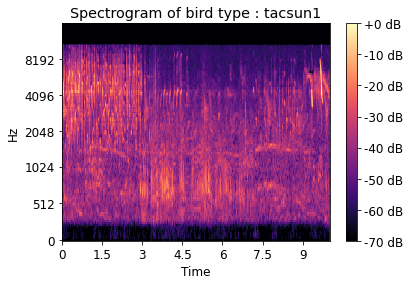

In [21]:
dec = npy.decode((x,y))
dec.show()

## Test transform class and functions

In [ ]:
labeller = parent_label
vals = list(map(labeller, items))
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
npy_transform = NpyTransform(vocab,o2i,labeller)

In [ ]:
x,y = npy_transform(items[0])
x.shape, y


In [ ]:
(x,y)

In [ ]:
dec = npy_transform.decode([x,y])
dec.show()

## Create Tfmdlists

In [20]:
# Parameters of the TfmdLists
labeller = parent_label
vals = class_names_from_csv(labels_csv_path)
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
npy_transform = NpyTransform()
splits = RandomSplitter(seed=42)(items)


In [21]:
tls = TfmdLists(items, [npy_transform], splits=splits)


In [43]:
dls = tls.dataloaders(bs=64)


In [36]:
from torchvision.models import resnet34, resnet50
opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8)

In [44]:

# define learner and train model
learn = vision_learner(dls, resnet18, opt_func=opt_func,metrics=error_rate, loss_func=CrossEntropyLossFlat)


In [46]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: ignored